In [1]:
%pylab inline
import astropy.units as u
import tmm
from Getindex import load_refraction_data
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)
import TMMSIM
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import astropy.units as u
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,epoxy_um,160, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T

    return(A)

# Define the gaussian function
@jit(nopython = True,nogil=True)
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)


@jit(nopython = True,nogil=True)
def map_sim(n_list,thickmap,wlen):
    Fringe_map = np.zeros_like(thickmap)
    for i in range(len(thickmap)):
        Fringe_map[i] = E2V_model(n_list = n_list,epoxy_um = thickmap[i],wlen=wlen)
    return(Fringe_map)

In [4]:
pol = 's'
wlen = 960
material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
n_list = np.array([index_of_refraction[m](wlen) for m in material])
thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,16.2,225, np.inf])
Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, 0.12, 1e-3 * wlen)
Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
print(Abor_prob)

0.5352959336351251


In [6]:
hh = fits.open('data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)

In [7]:
z = []
# y incident angle
th_min=14.38*u.deg 
th_max=23.92*u.deg
th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 1000)
# x wavelength
MAP = np.arange(17.,20.2,0.005)
wlen = 960
material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
n_list = np.array([index_of_refraction[m](wlen) for m in material])
pol = 's'
for j in tqdm(range(len(th_rad))):
    theta = th_rad[j]
    a = []
    for i in (range(len(MAP))):

        thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,MAP[i],165, np.inf])
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
        a.append(Abor_prob)
    z.append(a)

100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s]


In [8]:
from scipy import interpolate
x = MAP
y = th_rad
f = interpolate.interp2d(x, y, z, kind='cubic')

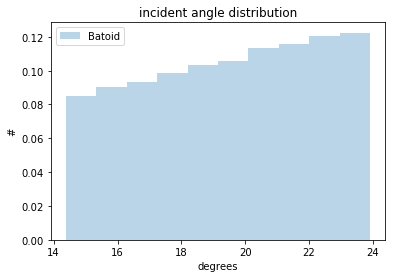

In [9]:
import batoid
telescope = batoid.Optic.fromYaml("LSST_r.yaml")
thx = np.deg2rad(0)
thy = np.deg2rad(0)
wavelength = 960e-9 # meters
rays = batoid.RayVector.asPolar(
    optic=telescope,
    wavelength=wavelength,
    theta_x=thx, theta_y=thy,
    nrad=1000, naz=3000  #  These control how many parallel rays are created
)
# Make "full trace" of a small random subset of rays for visualization down 
# below.  This isn't needed generally, it's just for the 3D vis below.
tf = telescope.traceFull(rays[np.random.choice(len(rays), 30)])

# Now trace through the system
telescope.trace(rays)
# Limit to unvignetted rays
rays = rays[~rays.vignetted]

dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz
#plt.hist(np.arctan(np.sqrt(dxdz**2+dydz**2))*180/np.pi,label = 'Fringing')

# We can convert these to a 1d histogram of incident angles
inc_thx, inc_thy = batoid.utils.dirCosToField(rays.vx, rays.vy, -rays.vz)
a,b,c= plt.hist(np.rad2deg(np.hypot(inc_thx, inc_thy)),label = 'Batoid',alpha = 0.3,density = True)
plt.xlabel("degrees")
plt.ylabel("#")
plt.legend(loc = 'best')
plt.title("incident angle distribution");

In [104]:

def decision(probability):
    return random.random() < probability

def Fringe_sim (inter_func,xz_slope,yz_slope,thickness):
    count = 0
    phi = np.arctan(np.sqrt(xz_slope**2+yz_slope**2))
    for i in range(len(phi)):
        z_new = inter_func(thickness,phi[i])
        # Determine if will be absorbed or not
        if decision(z_new) == True:
            count += 1
        else:
            count += 0
    return(count)

In [10]:
def decision(probability):
    compare = random.random(len(probability)) < probability
    mask = compare == True
    return(len(compare[mask]))
    #return(np.sum(probability))

def Fringe_sim (inter_func,xz_slope,yz_slope,thickness):
    phi = np.arctan(np.sqrt(xz_slope**2+yz_slope**2))
    z_new = inter_func(thickness,phi)
    z_new = z_new.reshape(len(z_new))
        # Determine if will be absorbed or not
    count = decision(z_new)
    return(count)

In [11]:
from tqdm import tqdm

In [12]:
dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz

fringing_res = np.zeros(shape=(200,200))

for i in tqdm(range(fringing_res.shape[0])):
    for j in range(fringing_res.shape[1]):
            choice = np.random.choice(len(dxdz_batoid),1000)
            #choice = np.random.choice(len(dxdz_batoid),10000)
            fringing_res[i,j] += Fringe_sim(inter_func=f,xz_slope=dxdz_batoid[choice],yz_slope = dydz_batoid[choice], thickness = Fitting[i,j])

100%|██████████| 200/200 [00:08<00:00, 22.92it/s]


In [13]:
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

# Define some function for plotting, adjusting the z-scale.

def cmap_range(image_array, nsig=3):
    pixel_data = np.array(image_array, dtype=np.float).flatten()
    stats = afwMath.makeStatistics(pixel_data,
                                   afwMath.STDEVCLIP | afwMath.MEDIAN)
    median = stats.getValue(afwMath.MEDIAN)
    stdev = stats.getValue(afwMath.STDEVCLIP)
    vmin = max(min(pixel_data), median - nsig*stdev)
    vmax = min(max(pixel_data), median + nsig*stdev)
    return vmin, vmax

def im_show (data):
    #plt.figure(figsize = (8,8))
    vmin, vmax = cmap_range(data)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    plt.imshow(data,origin='lower',norm=norm,cmap = pylab.cm.hot)
    plt.colorbar()

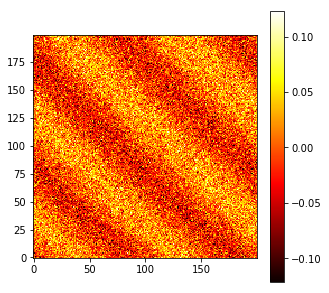

In [20]:
amp = True
plt.figure(figsize = (5,5))
if amp == True:
    g = np.mean(fringing_res)
    im_show(fringing_res/g-1)
    
else:
    im_show(fringing_res)

In [21]:
import pickle

In [22]:
filename = 'data/Full+Sim_960nm'
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()

In [23]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

Text(0, 0.5, 'Fringing amplitude')

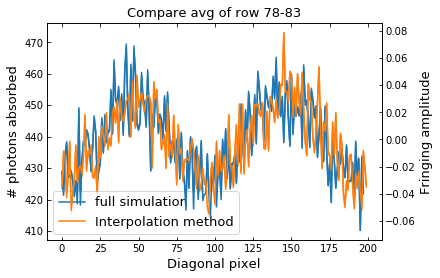

In [24]:
fig, ax1 = plt.subplots(figsize = (6,4))
plt.title('Compare avg of row 78-83',fontsize = 13)
ax2 = ax1.twinx()
ax1.plot(np.mean(new_dict[78:83,1:-1],axis=0),label = 'full simulation')
ax1.plot(np.mean(fringing_res[78:83,:],axis = 0),label = 'Interpolation method')

g = np.mean(np.mean(new_dict[78:83,1:-1],axis=0))
ax2.plot(np.mean(new_dict[78:83,1:-1],axis=0)/g-1,label = 'full simulation')
g = np.mean(np.mean(fringing_res[78:83,:],axis = 0))
ax2.plot(np.mean(fringing_res[78:83,:],axis = 0)/g-1,label = 'Interpolation method')

ax1.legend(loc = 'lower left',fontsize= 13)
ax1.set_xlabel('Diagonal pixel',fontsize = 13)
ax1.set_ylabel('# photons absorbed',fontsize = 13)
ax2.set_ylabel('Fringing amplitude',fontsize= 13)